 # Students Performance in Exams
 ## Data Impact Assessment - Tecnologie Digitali e Societa'
 ---
 ### Collaboratori (in ordine alfabetico):
 ##### Flavio Emanuele Cannavo'
 ##### Margheret Casaletto
 ##### Ambra Destino
 ##### Giuseppe Di Bartolomeo
 ##### Angelo Laudani
  

<h1>Sommario<span class="tocSkip"></span></h1><br>
<div class="toc">
    <ul class="toc-item">
    <li><span><a href="#p1" >Abstract</a></span></li>
    <li><span><a href="#p2" ><span class="toc-item-num">1&nbsp;&nbsp;</span>Analisi esplorativa</a></span></li>
    <li><span><a href="#p3" ><span class="toc-item-num">2&nbsp;&nbsp;</span>Classificazione</a></span></li>
    <li><span><a href="#p4" ><span class="toc-item-num">3&nbsp;&nbsp;</span>Criterio Sufficienza</a></span></li>
    <li><span><a href="#p5" ><span class="toc-item-num">4&nbsp;&nbsp;</span>Criterio Separazione</a></span></li>
    <li><span><a href="#p6" ><span class="toc-item-num">5&nbsp;&nbsp;</span>Fattori di Rischio e Conclusioni</a></span></li>
    </ul>
</div>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

['StudentsPerformance.csv']


<a id='p1'></a>

# Abstract

 Il dataset di partenza contiene un totale di 1000 osservazioni con i seguenti attributi:
 * **gender**: male/female
 * **race/ethnicity**: cinque differenti gruppi (fittizi) - A,B,C,D,E
 * **parental level of education**:
     masters, bachelors, associate, some college, high school, some high school (in ordine discendente, il "some" indica il non completamento degli studi)
 * **lunch**: standard/free or reduced
 * **test preparation course**: none/completed
 * **math score**
 * **reading score**
 * **writing score**
 
L'obiettivo dell'analisi è la verifica dell'omogeneità dei dati e l'utilizzo di criteri di equità per capire come la distribuzione originale del dataset, qualora affetta da bias intrinseci, possa influenzare i risultati ottenuti dai modelli di apprendimento automatico.

 Viene verificato se i gruppi etnici rappresentati nel dataset sono distribuiti in modo omogeneo per etnia e genere, ovvero se ciascun gruppo all'interno del dataset viene rappresentato da un numero di individui equiparabile.

Ulteriore attenzione viene rivolta all'osservazione dell'attributo "lunch", in quanto si rivela indice di una condizione sociale particolare. Infatti, gli studenti possono usufruire di pasti gratis o ridotti attraverso la partecipazione a cosiddetti *Federal Assistance Programs*  o in base alla loro condizione di senza tetto, immigrati, rifugiati, o in affidamento. A questi casi particolari inoltre si aggiungono il reddito familiare e la grandezza della famiglia (https://www.fns.usda.gov/nslp/nslp-fact-sheet). 
     
Si verifica inoltre come impattino sui risultati finali il genere, l'educazione dei genitori, e il completamento della preparazione al test osservando la correlazione tra  gli attributi.

L'analisi si conclude, grazie all'applicazione dei criteri di sufficienza e di separazione, individuando la presenza di fattori di rischio legati agli attributi sensibili ethnicity e lunch, che inducono il classificatore ad un alto tasso di predizioni erronee.

---




<a id='p2'></a>

# 1. Analisi Esplorativa

In [2]:
# import and loading
df = pd.read_csv("../input/StudentsPerformance.csv")

### Si osservi il dataset dopo qualche piccola modifica:

In [3]:
# data cleaning
df.rename(columns={"race/ethnicity": "ethnicity", 
"parental level of education":"parent_education",
"test preparation course":"preparation",
"math score":"m_score",
"reading score": "r_score",
"writing score": "w_score"}, inplace = True)

# feature engineering on the data to visualize and solve the dataset more accurately
df['avg_score'] = (df['m_score'] + df['r_score'] + df['w_score'])/3
df.head()

,gender,ethnicity,parent_education,lunch,preparation,m_score,r_score,w_score,avg_score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


### Verifica della presenza di righe nulle:

In [4]:
df.isnull().sum()

gender              0
ethnicity           0
parent_education    0
lunch               0
preparation         0
m_score             0
r_score             0
w_score             0
avg_score           0
dtype: int64

### Correlazione delle features numeriche:

In [5]:
# start data exploration
corr=df.corr()
corr

,m_score,r_score,w_score,avg_score
m_score,1.000000,0.817580,0.802642,0.918746
r_score,0.817580,1.000000,0.954598,0.970331
w_score,0.802642,0.954598,1.000000,0.965667
avg_score,0.918746,0.970331,0.965667,1.000000


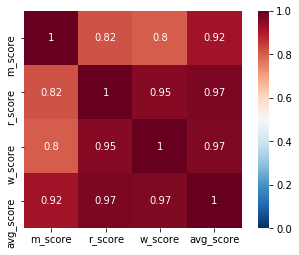

In [6]:
ax = sns.heatmap(corr, annot=True, square=True, vmin=0, vmax=1, cmap="RdBu_r")

Nell'analisi della correlazione non viene presa in considerazione la correlazione con l'attributo 'avg_score' essendo questo derivato matematicamente dagli altri tre punteggi. Si può comunque notare un alto fattore di correlazione tra i tre punteggi, in particolar modo tra 'w_score' e 'r_score'. 

### Statistiche riassuntive riguardo le features numeriche:

In [7]:
df.describe()

,m_score,r_score,w_score,avg_score
count,1000.00000,1000.000000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000,67.770667
std,15.16308,14.600192,15.195657,14.257326
min,0.00000,17.000000,10.000000,9.000000
25%,57.00000,59.000000,57.750000,58.333333
50%,66.00000,70.000000,69.000000,68.333333
75%,77.00000,79.000000,79.000000,77.666667
max,100.00000,100.000000,100.000000,100.000000


### Numero di studenti per ogni gruppo:

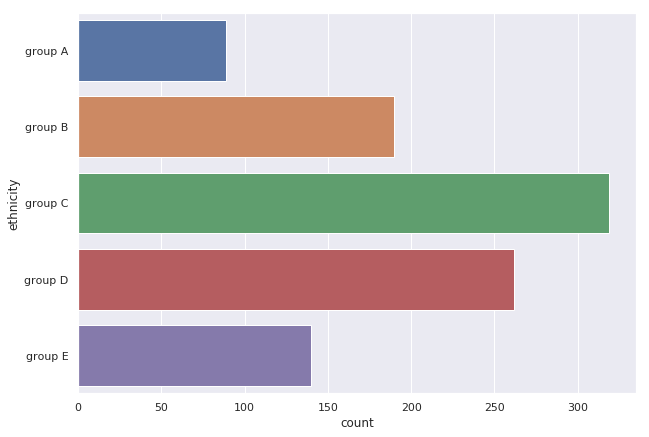

In [8]:
sns.set(rc={'figure.figsize':(10,7)})
sns.countplot(y = "ethnicity", data = df.sort_values("ethnicity"))
plt.show()

La distribuzione dei gruppi è abbastanza eterogenea e si possono individuare due **minoranze**, gruppo A e gruppo E, che sono rappresentate con un numero di elementi minore della metà del gruppo predominante, gruppo C. 

### Numero di studenti per ogni genere:

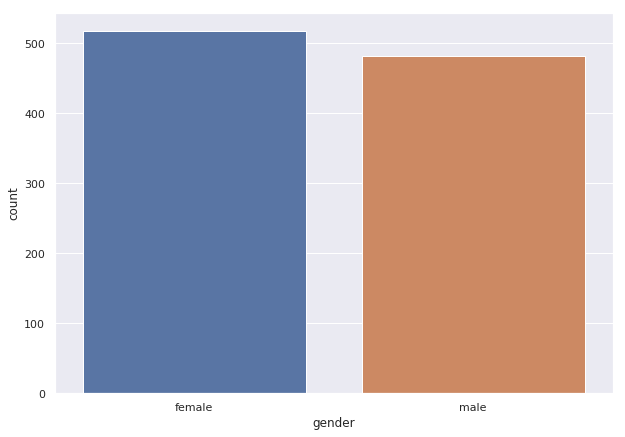

In [9]:
sns.countplot(x = "gender", data = df)
plt.show()

Si può notare una distribuzione pressochè omogenea, con una piccola maggioranza nel gruppo 'female'. 

### Numero di studenti per ogni genere all'interno di ogni gruppo:

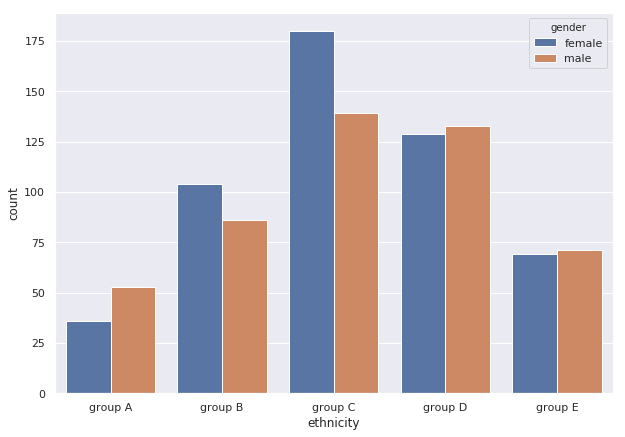

In [10]:
sns.countplot(x = "ethnicity", hue="gender", data = df.sort_values("ethnicity"))
plt.show()

Il **gruppo C** è quello più numeroso, ma anche quello con il rapporto più grande di presenza femminile.

### Numero di studenti in base alla *"Parental Education"*:

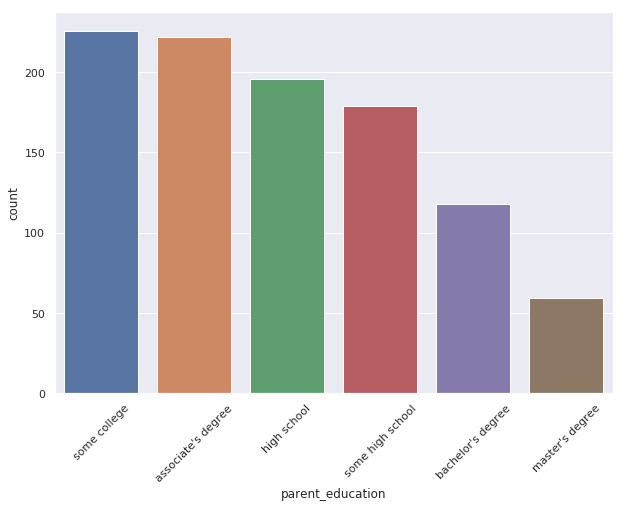

In [11]:
# visualizing the differnt parental education levels
sns.countplot(x = "parent_education", data = df, order=df['parent_education'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

### Distribuzione dei voti al variare del livello di educazione dei genitori:

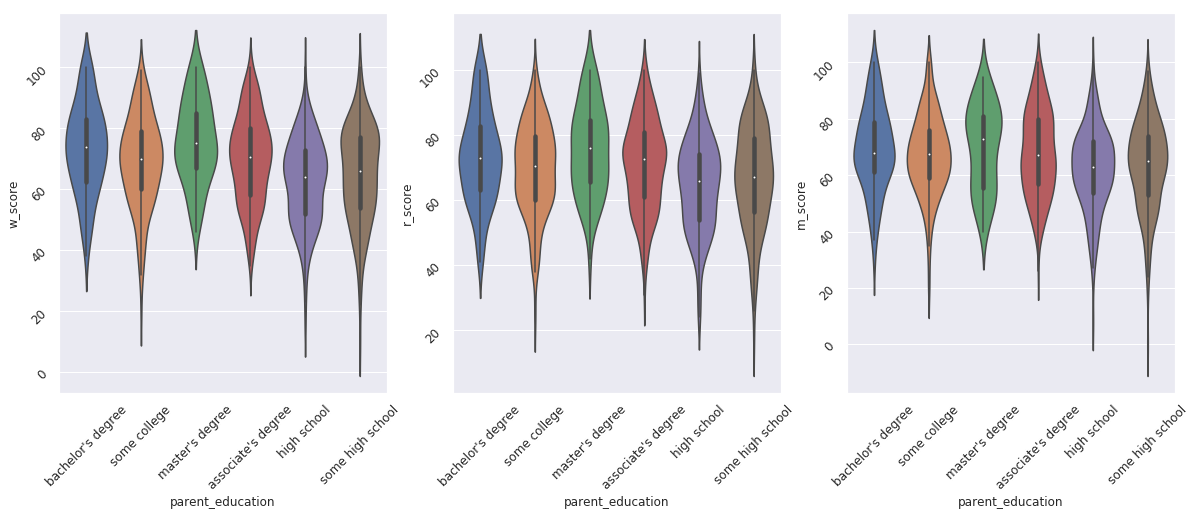

In [12]:
# Come varia la distribuzione dei voti al variare del livello di educazione dei genitori?"
sns.set(rc={'figure.figsize':(20,7)})
fig, axs = plt.subplots(ncols=3)

sns.violinplot(x = "parent_education", y = "w_score",  data = df, ax=axs[0])
sns.violinplot(x = "parent_education", y = "r_score",  data = df, ax=axs[1])
sns.violinplot(x = "parent_education", y = "m_score",  data = df, ax=axs[2])
for ax in axs:
    ax.tick_params(labelrotation=45)
    ax.tick_params(labelsize=12)
plt.show()


I figli dei laureati hanno tendenzialmente punteggi migliori.

### Distribuzione dei voti a seconda del gruppo etnico:

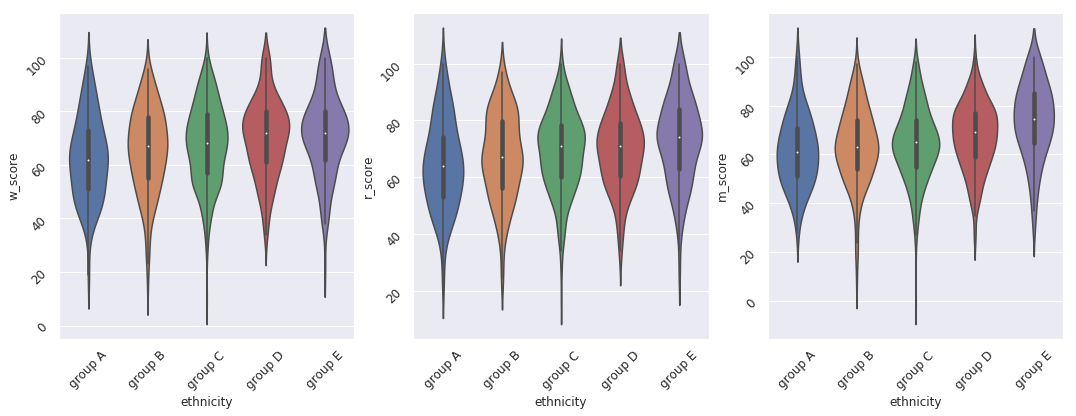

In [13]:
# Come varia tra i gruppi la distribuzione dei voti?
sns.set(rc={'figure.figsize':(18,6)})
fig, axs = plt.subplots(ncols=3)

sns.violinplot(x = "ethnicity", y = "w_score",  data = df.sort_values('ethnicity'), ax=axs[0])
sns.violinplot(x = "ethnicity", y = "r_score",  data = df.sort_values('ethnicity'), ax=axs[1])
sns.violinplot(x = "ethnicity", y = "m_score",  data = df.sort_values('ethnicity'), ax=axs[2])
for ax in axs:
    ax.tick_params(labelrotation=45,labelsize=12)
plt.show()

Il **gruppo E** presenta valutazioni migliori degli altri.

### Distribuzione dei voti al variare del genere:

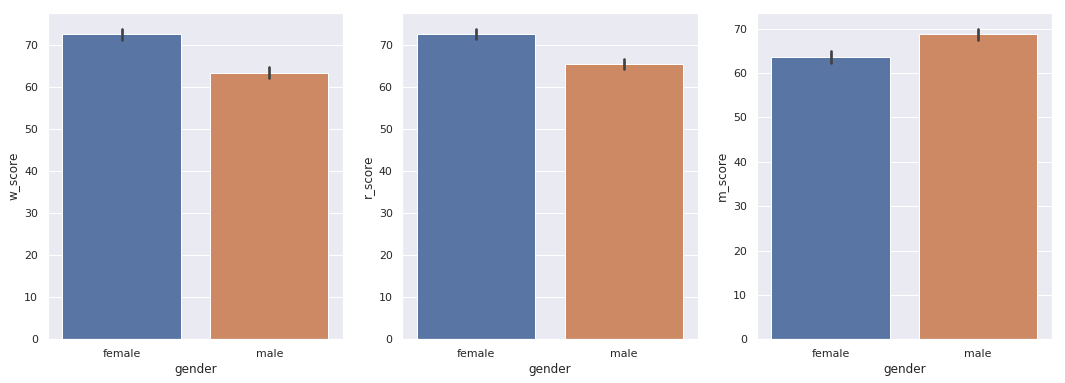

In [14]:
# Come varia tra i generi la distribuzione dei voti?
sns.set(rc={'figure.figsize':(18,6)})
fig, axs = plt.subplots(ncols=3)

sns.barplot(x = "gender", y = "w_score",  data = df, ax=axs[0])
sns.barplot(x = "gender", y = "r_score",  data = df, ax=axs[1])
sns.barplot(x = "gender", y = "m_score",  data = df, ax=axs[2])

plt.show()

Il grafico rappresenta il punteggio medio per ogni materia, tra i vari individui suddivisi per genere. Le donne vengono superate dagli uomini solo in matematica.

### Relazione tra il tipo di pasto e distribuzione voti:

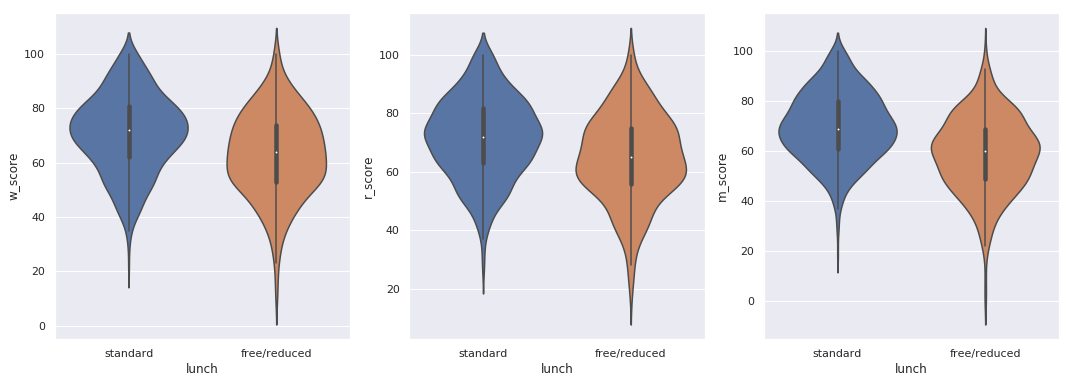

In [15]:
# Come influisce il tipo di pasto sulla distribuzione dei voti?
sns.set(rc={'figure.figsize':(18,6)})
fig, axs = plt.subplots(ncols=3)

sns.violinplot(x = "lunch", y = "w_score",  data = df, ax=axs[0])
sns.violinplot(x = "lunch", y = "r_score",  data = df, ax=axs[1])
sns.violinplot(x = "lunch", y = "m_score",  data = df, ax=axs[2])

plt.show()

Gli studenti che assumono un pasto completo (si suppone dunque abbiano una situazione economica agiata) hanno una media dei voti sostanzialmente più alta in tutte le materie.

### Relazione tra il tipo di pasto e media dei voti al variare del gruppo:

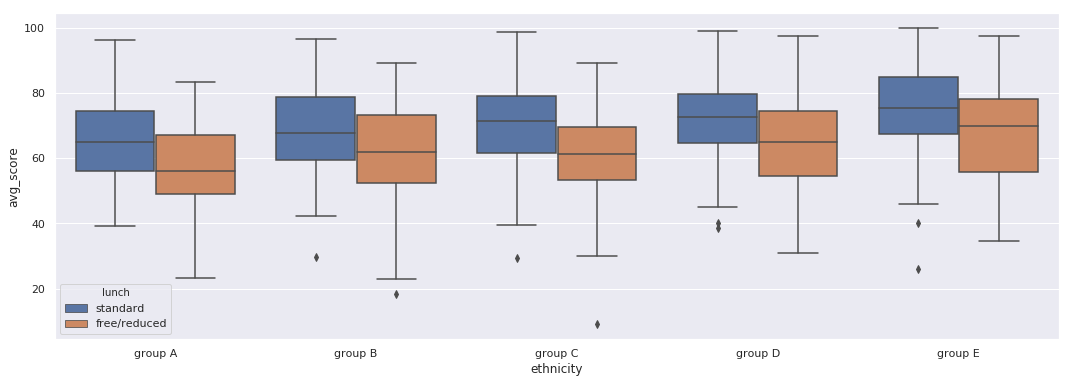

In [16]:
# Come influisce il tipo di pasto sulla distribuzione dei voti?
sns.boxplot(x = "ethnicity", y = "avg_score",  data = df.sort_values("ethnicity"), hue="lunch")

plt.show()

Il gruppo di minoranza A sembra essere quello che soffre di più l'influenza negativa del 'free/reduced' lunch (la distanza dal centro del box, indice del suo valore medio, rispetto al suo margine superiore è più grande di tutte le altre).

### Ripartizione di studenti con pasto intero o ridotto all'interno dei vari gruppi:

In [17]:
df.groupby("lunch")["ethnicity"].value_counts().unstack()

ethnicity,group A,group B,group C,group D,group E
lunch,,,,,
free/reduced,36,69,114,95,41
standard,53,121,205,167,99


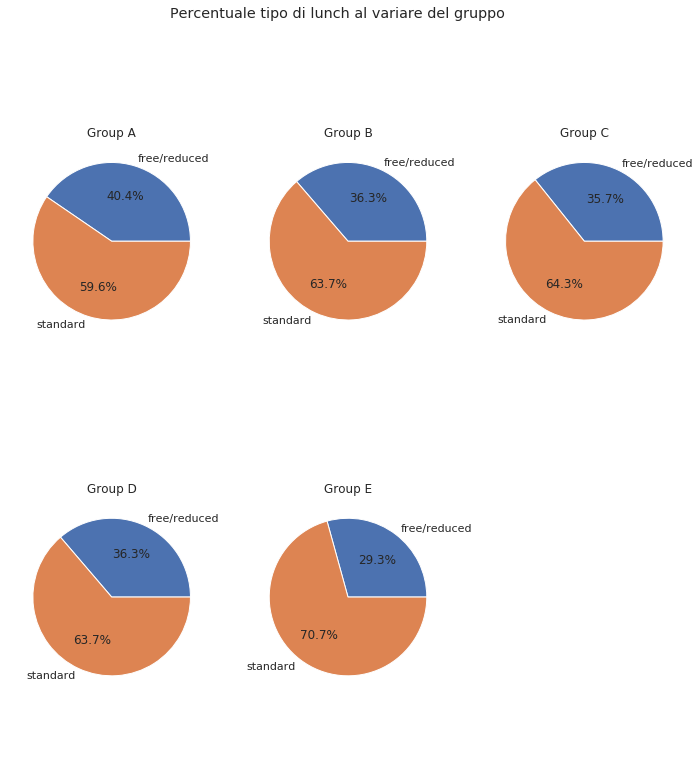

In [18]:
v = df.groupby("lunch")["ethnicity"].value_counts().unstack()
lunch_ratio = v.div(v.sum(axis="rows"), axis="columns")

fig, axs = plt.subplots(2, 3, figsize=(12,12))
fig.suptitle('Percentuale tipo di lunch al variare del gruppo')
axs[0, 0].pie(lunch_ratio["group A"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[0, 0].set_title('Group A')
axs[0, 1].pie(lunch_ratio["group B"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[0, 1].set_title('Group B')
axs[0, 2].pie(lunch_ratio["group C"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[0, 2].set_title('Group C')
axs[1, 0].pie(lunch_ratio["group D"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[1, 0].set_title('Group D')
axs[1, 1].pie(lunch_ratio["group E"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[1, 1].set_title('Group E')
axs[1, 2].axis('off')

plt.show()

Il rapporto tra studenti con pasto "standard" e con pasto "reduced" è circa uguale in tutti i gruppi, con l'eccezione del **gruppo E** che presenta una più marcata predominanza di studenti con pasto "standard". Si può dunque supporre che il **gruppo E** sia il più benestante

### Ripartizione dei pasti, intero o ridotto, a seconda dei diversi titoli di studio dei genitori:

In [19]:
df.groupby("lunch")["parent_education"].value_counts().unstack()

parent_education,associate's degree,bachelor's degree,high school,master's degree,some college,some high school
lunch,,,,,,
free/reduced,77,44,70,24,79,61
standard,145,74,126,35,147,118


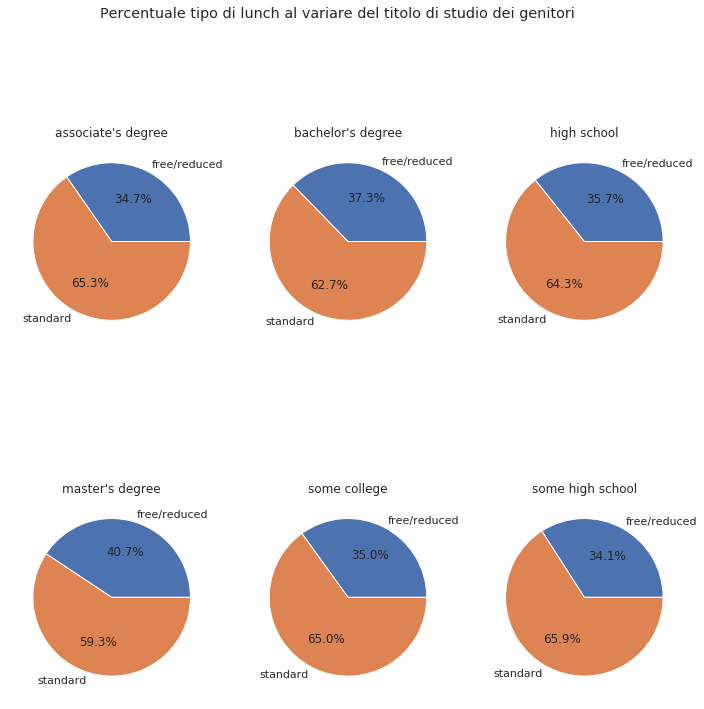

In [20]:
v = df.groupby("lunch")["parent_education"].value_counts().unstack()
lunch_ratio = v.div(v.sum(axis="rows"), axis="columns")

fig, axs = plt.subplots(2, 3, figsize=(12,12))
fig.suptitle('Percentuale tipo di lunch al variare del titolo di studio dei genitori')
axs[0, 0].pie(lunch_ratio["associate's degree"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[0, 0].set_title("associate's degree")
axs[0, 1].pie(lunch_ratio["bachelor's degree"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[0, 1].set_title("bachelor's degree")
axs[0, 2].pie(lunch_ratio["high school"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[0, 2].set_title("high school")
axs[1, 0].pie(lunch_ratio["master's degree"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[1, 0].set_title("master's degree")
axs[1, 1].pie(lunch_ratio["some college"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[1, 1].set_title("some college")
axs[1, 2].pie(lunch_ratio["some high school"], labels=lunch_ratio.index.values, autopct='%1.1f%%')
axs[1, 2].set_title("some high school")

plt.show()

Il rapporto rimane pressoché uguale al variare del livello d'istruzione dei genitori. Interessante notare come siano i figli di genitori con "master's degree" ad essere quelli con il più alto numero di pasto "reduced" rispetto a "standard" nonostante il più elevato livello d'istruzione da parte dei genitori (tale anomalia potrebbe essere legata al basso numero di osservazioni per questa specifica categoria).

### Numero di ragazzi e ragazze che decidono di completare il test di preparazione:

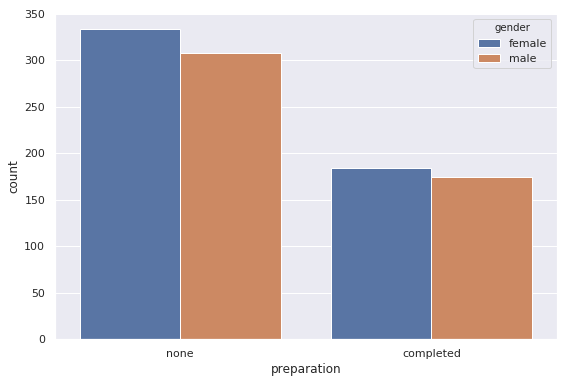

In [21]:
plt.figure(figsize=(9,6))
sns.countplot(x = "preparation", hue="gender", data = df)

plt.show()

Si evince che soltanto poco più di un terzo degli studenti, indipendentemente dal genere, completa la preparazione al test.

### Relazione tra preparazione ai test e punteggi conseguiti:

Nel primo grafico si tiene in considerazione anche il genere. 

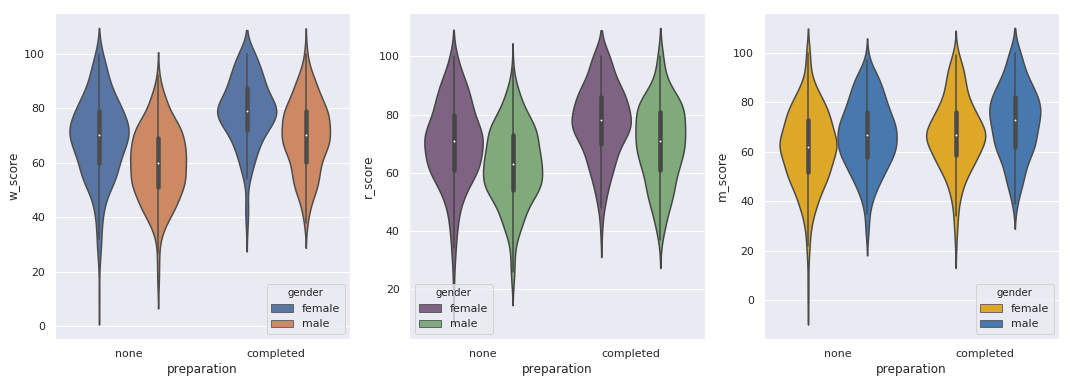

In [22]:
fig, axs = plt.subplots(ncols=3)
colors = [ "amber", "windows blue","dusty purple","faded green", ]
color = sns.xkcd_palette(colors)

sns.violinplot(x = "preparation", y = "w_score", hue="gender", data = df, ax=axs[0])
sns.violinplot(x = "preparation", y = "r_score",  hue="gender", data = df, ax=axs[1],palette=color[2:])
sns.violinplot(x = "preparation", y = "m_score",  hue="gender", data = df, ax=axs[2], palette=color)
plt.show()

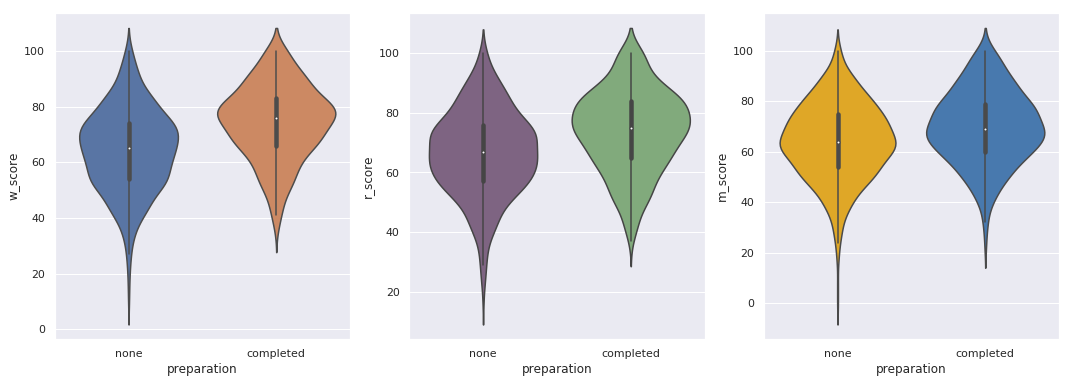

In [23]:
fig, axs = plt.subplots(ncols=3)
colors = [ "amber", "windows blue","dusty purple","faded green", ]
color = sns.xkcd_palette(colors)

sns.violinplot(x = "preparation", y = "w_score",  data = df, ax=axs[0])
sns.violinplot(x = "preparation", y = "r_score",  data = df, ax=axs[1],palette=color[2:])
sns.violinplot(x = "preparation", y = "m_score", data = df, ax=axs[2], palette=color)
plt.show()

Il primo grafico mette in luce che il completamento della preparazione per affrontare i test permette di ottenere risultati migliori nelle prove (circa 5-10 punti in più) rispetto a chi non li completa, indipendentemente dal genere.

Per completezza è stato rappresentato anche un grafico che fa riferimento alla preparazione al test in base al punteggio ottenuto, senza distinzione di genere. In esso vengono confermati gli stessi risultati.

### Relazione tra 'Parent Education' e preparazione al test a seconda del gruppo etnico:

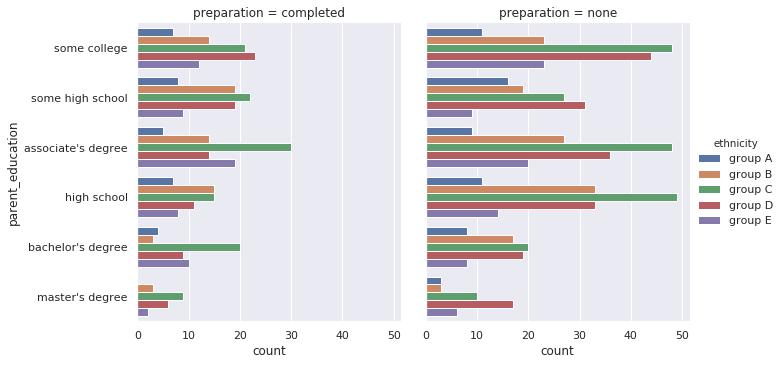

In [24]:
sns.catplot(y="parent_education", hue="ethnicity", col="preparation", data=df.sort_values('ethnicity'), kind="count")
plt.show()

Effettuando una separazione per gruppo etnico e per livello di educazione dei genitori si ottengono alcune distribuzioni diverse da quella di partenza. 
In questa analisi si definisce una distribuzione in **controtendenza**, rispetto alla distribuzione generale esaminata in precedenza, se:
>il numero di studenti che completano il test di preparazione è uguale (o superiore) a quello degli studenti che non completano il test di preparazione

Nel gruppo A
* **Tutti i ragazzi** figli di laureati magistrali **decidono di non prepararsi al test**.

Nel gruppo B
* Sebbene i figli di laureati triennali, che per la maggior parte preferiscono non prepararsi, abbiano all'incirca gli stessi risultati (poco inferiori) dei **figli di laureati magistrali**, questi ultimi sono in **controtendenza**.

* Nei restanti livelli di istruzione, la situazione rispecchia quella generale, ma c'e' un'ulteriore anomalia tra **i figli di persone che non hanno completato gli studi** (*some high school*), infatti anche questi sono in **controtendenza**.

Nel gruppo C
* **Controtendenza** dei ragazzi figli di **laureati triennali**.
* Tra i figli di **laureati magistrali**, seppur non vi sia controtendenza, è interessante notare un equilibiro maggiore rispetto all'andamento generale.

Nel gruppo D
* Rispecchia l'andamento generale senza particolari anomalie.

Nel gruppo E
* **Controtendenza** dei ragazzi figli di **laureati triennali**, i quali **per la maggior parte decidono di prepararsi al test**.
* **Controtendenza** dei ragazzi figli di genitori che **non hanno completato gli studi**.
* Seppur non vi sia controtendenza, è presente un maggiore equilibrio nella scelta dei ragazzi **figli di genitori con diploma associato**.  

### Score ottenuti nelle varie materie:
Le materie sono tre: *reading*, *writing* e *mathematic*.

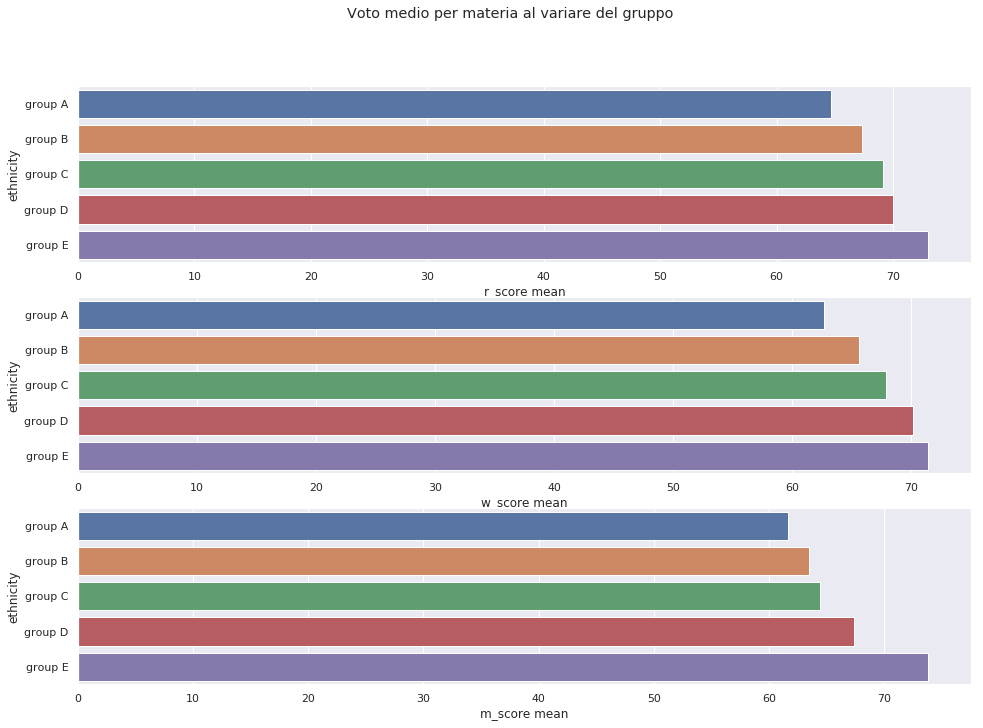

In [25]:
# Data to plot
labels = ['group A', 'group B', 'group C', 'group D','group E']
sizes_r = df.groupby('ethnicity')['r_score'].mean().values
sizes_w = df.groupby('ethnicity')['w_score'].mean().values
sizes_m = df.groupby('ethnicity')['m_score'].mean().values
 
# Plot
sns.set(rc={'figure.figsize':(16,11)})
fig, axs = plt.subplots(nrows=3)
fig.suptitle('Voto medio per materia al variare del gruppo')
ax = sns.barplot(y=labels ,x=sizes_r,data=df, ax = axs[0])
ax.set(ylabel='ethnicity', xlabel='r_score mean')
ax = sns.barplot(y=labels ,x=sizes_w,data=df, ax = axs[1])
ax.set(ylabel='ethnicity', xlabel='w_score mean')
ax = sns.barplot(y=labels ,x=sizes_m,data=df, ax = axs[2])
ax.set(ylabel='ethnicity', xlabel='m_score mean')
plt.show() 


### Modifica del dataset di partenza con l'integrazione di alcune informazioni utili per ulteriori statistiche:
* **grades**: una valutazione complessiva ricavata dalla media dei voti e basata sul sistema americano.

   [ A: 90-100
    B: 80-89
    C: 70-79
    D: 60-69
    F: 0-59 ]
* **status**: indica se lo studente ha superato tutte le materie (superando una certa soglia di voto scelta pari a 60, corrispondente ad una valutazione superiore ad "F").

Gli studenti che non hanno superato tutte le materie ottengono un "Fail" come valutazione finale.

In [26]:
# Assigning grades to the grades according to the following criteria :
# A: 90-100
# B: 80-89
# C: 70-79
# D: 60-69
# F: 0-59

def getgrade(score):
  if(score >= 90):
    return 'A'
  if(score >= 80):
    return 'B'
  if(score >= 70):
    return 'C'
  if(score >= 60):
    return 'D'
  else:
    return 'F'

df['grades_w'] = df.apply(lambda x: getgrade(x['w_score']), axis = 1 )
df['grades_r'] = df.apply(lambda x: getgrade(x['r_score']), axis = 1 )
df['grades_m'] = df.apply(lambda x: getgrade(x['m_score']), axis = 1 )

df.head(5)


,gender,ethnicity,parent_education,lunch,preparation,m_score,r_score,w_score,avg_score,grades_w,grades_r,grades_m
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667,C,C,C
1,female,group C,some college,standard,completed,69,90,88,82.333333,B,A,D
2,female,group B,master's degree,standard,none,90,95,93,92.666667,A,A,A
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333,F,F,F
4,male,group C,some college,standard,none,76,78,75,76.333333,C,C,C


### Distribuzione dei voti ottenuti nelle varie materie:

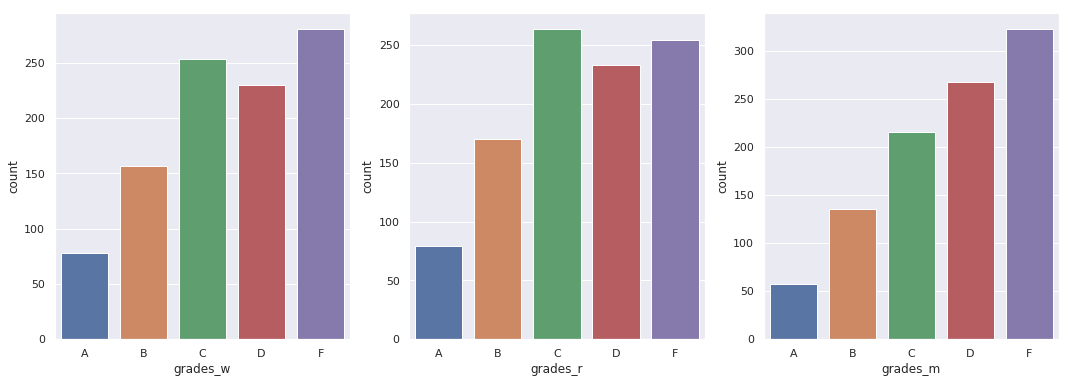

In [27]:
sns.set(rc={'figure.figsize':(18,6)})
fig, axs = plt.subplots(ncols=3)

sns.countplot(x = "grades_w", data = df.sort_values('grades_w'), ax=axs[0])
sns.countplot(x = "grades_r", data = df.sort_values('grades_r'), ax=axs[1])
sns.countplot(x = "grades_m", data = df.sort_values('grades_m'), ax=axs[2])
plt.show()

La distribuzione dei voti è circa uguale in *writing* e *reading*. Invece *mathematic* presenta dei voti tendenzialmente peggiori.

### Numero studenti che non presentano valutazioni insufficienti:
Gli studenti con esito "Pass" hanno ottenuto una valutazione superiore ad F (insufficienza) in tutte e tre le materie.

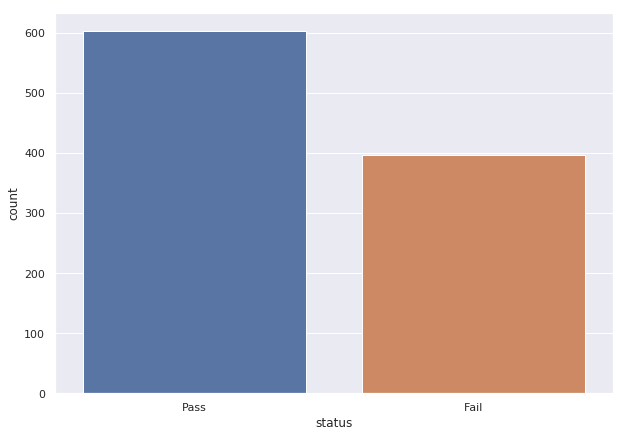

In [28]:
# setting a passing mark for the students to pass on the three subjects individually
passmarks = 60

# creating a new column pass_math, this column will tell us whether the students are pass or fail
df['pass_math'] = np.where(df['m_score']< passmarks, 'Fail', 'Pass')
df['pass_reading'] = np.where(df['r_score']< passmarks, 'Fail', 'Pass')
df['pass_writing'] = np.where(df['w_score']< passmarks, 'Fail', 'Pass')

# checking which student is fail overall

df['status'] = df.apply(lambda x : 'Fail' if x['pass_math'] == 'Fail' or 
                           x['pass_reading'] == 'Fail' or x['pass_writing'] == 'Fail'
                           else 'Pass', axis = 1)

sns.set(rc={'figure.figsize':(10,7)})
sns.countplot(x = "status", data = df)
plt.show()

### Studenti senza insufficienze divisi per gruppo etnico:

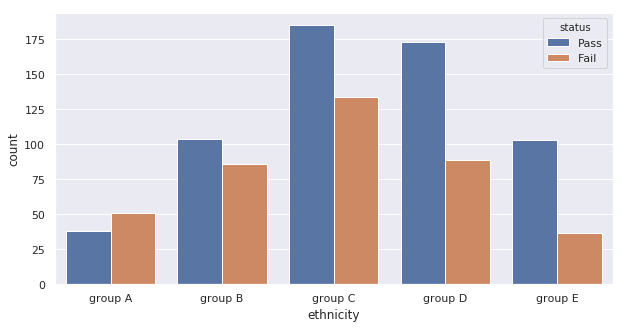

In [29]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x = "ethnicity", hue="status", data = df.sort_values("ethnicity"))
plt.show()

Il **gruppo A** è l'unico con un numero di esiti negativi maggiore rispetto a quelli positivi. 
Il **gruppo E** è invece quello con il più alto rapporto di promossi rispetto a bocciati.

<a id='p3'></a>

# 2. Classificazione

Per la classificazione si prende in considerazione un dataset ridotto, costituito solo da alcuni attributi del dataset di partenza, quali: 
gender, ethnicity, parent_education, lunch, preparation. 
Come etichetta per la classificazione viene usato l'attributo status. 
Non sono state considerate le grandezze r_score, w_score, m_score e grades_r, grades_w, grades_m poichè 
direttamente correlate con 'status'. 

In [30]:
X_fair=pd.DataFrame(df[["gender", "ethnicity", "parent_education", "lunch", "preparation","status"]])
X=pd.DataFrame(df[["gender", "ethnicity", "parent_education", "lunch", "preparation"]])
label=df["status"]
X.head(5)

,gender,ethnicity,parent_education,lunch,preparation
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none


In [31]:
from sklearn.preprocessing import LabelEncoder

X["gender"]=LabelEncoder().fit_transform(X["gender"])
X["ethnicity"]=LabelEncoder().fit_transform(X["ethnicity"])
X["parent_education"]=LabelEncoder().fit_transform(X["parent_education"])
X["lunch"]=LabelEncoder().fit_transform(X["lunch"])
X["preparation"]=LabelEncoder().fit_transform(X["preparation"])

X.head(5)

,gender,ethnicity,parent_education,lunch,preparation
0,0,1,1,1,1
1,0,2,4,1,0
2,0,1,3,1,1
3,1,0,0,0,1
4,1,2,4,1,1


Dopo aver correttamente codificato le varie classi del dataset si prosegue con la classificazione, eseguendo un processo di training e test su diversi tipi di classificatore:

Linear SVM
Score on test set: 0.635
Accuracy: 0.65 (+/- 0.05)
precision: [0.53846154 0.69672131]
recall: [0.53164557 0.70247934]
fscore: [0.53503185 0.69958848]
support: [ 79 121]
confusion matrix: 
[[42 37]
 [36 85]]

____________________________________________
Random Forest
Score on test set: 0.630
Accuracy: 0.63 (+/- 0.04)
precision: [0.53846154 0.67407407]
recall: [0.44303797 0.75206612]
fscore: [0.48611111 0.7109375 ]
support: [ 79 121]
confusion matrix: 
[[35 44]
 [30 91]]

____________________________________________
Log Regression
Score on test set: 0.645
Accuracy: 0.67 (+/- 0.06)
precision: [0.56896552 0.67605634]
recall: [0.41772152 0.79338843]
fscore: [0.48175182 0.73003802]
support: [ 79 121]
confusion matrix: 
[[33 46]
 [25 96]]

____________________________________________


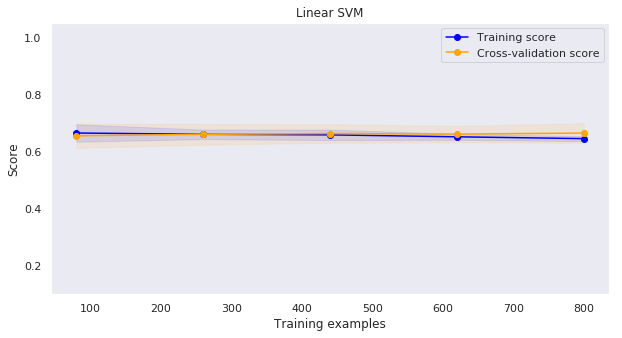

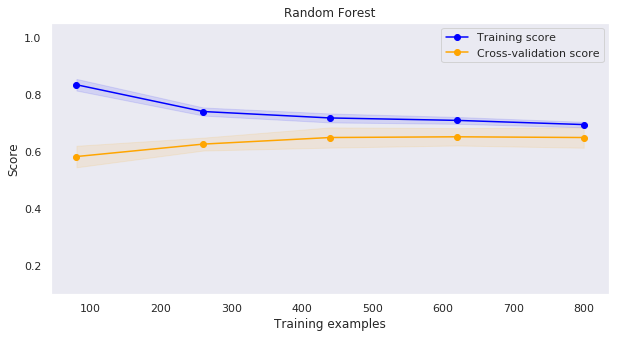

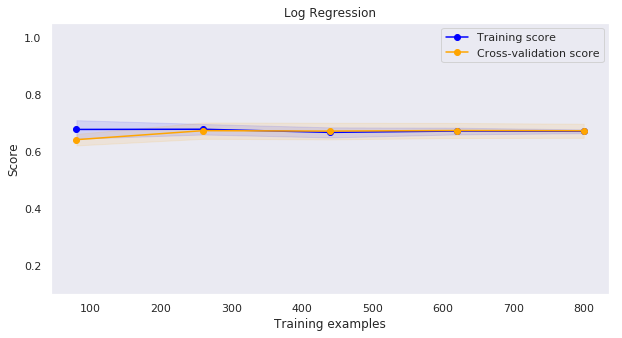

In [32]:
X_train, X_test, y_train, y_test =  train_test_split(X, label, test_size=0.2, random_state=0)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "AdaBoost", "Naive Bayes", "QDA", 
    "Random Forest", "Decision Tree", "Log Regression"]

names = ["Linear SVM", "Random Forest", "Log Regression"]

classifiers = [
    #KNeighborsClassifier(3),
    SVC(kernel="linear", C=1, probability=1, random_state=1),
    #SVC(gamma=1, C=1, probability=1, random_state=1),
    #AdaBoostClassifier(random_state=1),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis(), 
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=1),
    #DecisionTreeClassifier(max_depth=5, random_state=1),
    LogisticRegression(C=1, random_state=2, solver='lbfgs')]


xx, yy = np.mgrid[-1:2:.01, -1:2:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
decision_tree=0
fi=0
fi1=0
confusion_matrixs=[]

for name, model, ax in zip(names, classifiers, grid.flatten() ):
    clf = model.fit(X_train, y_train) 
    a=clf.score(X_test, y_test)
    #if name == "Decision Tree":
        #decision_tree=clf
        #fi=np.array(sorted(zip(X.columns[0:], clf.feature_importances_), key=lambda x: x[1], reverse=False))
    if name == ('Random Forest'):
        fi1=np.array(sorted(zip(X.columns[0:], clf.feature_importances_), key=lambda x: x[1], reverse=False))
    print(name)
    print("Score on test set: %0.3f" % (a))
    scores = cross_val_score(clf, X, label, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    predict = clf.predict(X_test)	
    cm=confusion_matrix(y_test, predict)
    confusion_matrixs.append(cm)

    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    plot_learning_curve(model, name, X, label, ylim=(0.1, 1.05), cv=cv, n_jobs=-1)
    
    
    precision, recall, fscore, support = score(y_test, predict)
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))
    print('confusion matrix: ')
    print(cm)
    print()
    print("____________________________________________")    
    
 

I classificatori utilizzati, di cui viene visualizzato un grafico che mostra il relativo punteggio "score" ottenuto in fase di training e di cross-validation, sono: *SVM Lineare*, *Random Forest* e *Logistic Regression*.

L'accuratezza dei classificatori si attesta intorno al **63%**

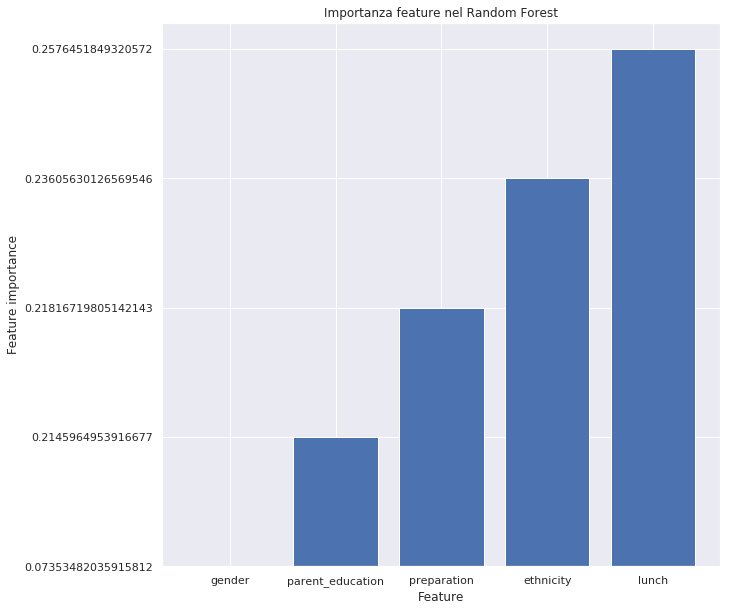

In [33]:
fig=plt.figure(figsize=(10, 10))
plt.bar(
    x=fi1[:, 0],
    height=fi1[:, 1],
    tick_label=fi1[:, 0]
)
plt.ylabel('Feature importance')
plt.xlabel('Feature')
plt.title('Importanza feature nel Random Forest')
plt.show()

La feature di maggiore rilevanza, nel caso del "Random Forest", rimane 'lunch' seguita da 'ethnicity'. L'attributo 'gender' sembra non avere alcuna rilevanza nel decisore.

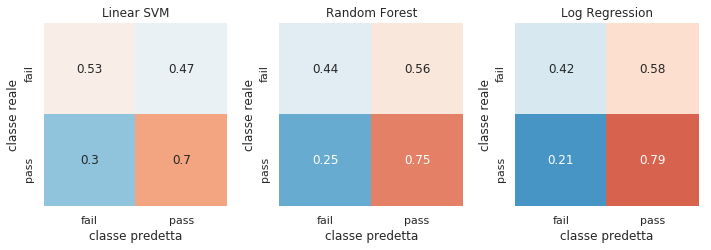

In [34]:
if (len(names) <= 3):
    fig, axs = plt.subplots(nrows=1, ncols=3)
elif ((len(names) > 3) & (len(names) <= 6)):
    fig, axs = plt.subplots(nrows=2, ncols=3)
else:
    fig, axs = plt.subplots(nrows=3,ncols=3)
    
fig.tight_layout(h_pad=5)
sns.set(rc={'figure.figsize':(20,10)})

for i, cm , name in zip(enumerate(names), confusion_matrixs, names):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalizzo cm
    
    df_cm = pd.DataFrame(cm, index = ['fail', 'pass'],
                  columns = ['fail', 'pass'])
    
    if(i[0]<3):
        ax = sns.heatmap(df_cm, annot=True, square=True, vmin=0, vmax=1, cbar=False, cmap="RdBu_r", ax=axs[i[0] % 3])
    elif((i[0] >= 3) & (i[0]<6)):
        ax = sns.heatmap(df_cm, annot=True, square=True, vmin=0, vmax=1, cbar=False, cmap="RdBu_r", ax=axs[1,i[0] % 3])
    else:
        ax = sns.heatmap(df_cm, annot=True, square=True, vmin=0, vmax=1, cbar=False, cmap="RdBu_r", ax=axs[2,i[0] % 3])
    ax.set(title=name, ylabel='classe reale', xlabel='classe predetta')

Si considerino ora le matrici di confusione dei vari classificatori utilizzati.

In [35]:
predict = clf.predict(X)
df_predictions = pd.DataFrame(predict)
X_fair["predicted"] = df_predictions

Al dataframe viene aggiunto l'esito del classificatore per ogni elemento, al fine di poter effettuare una più agevole valutazione dei paramentri di *"fairness"*.

In [36]:
X_fair.head(5)

,gender,ethnicity,parent_education,lunch,preparation,status,predicted
0,female,group B,bachelor's degree,standard,none,Pass,Pass
1,female,group C,some college,standard,completed,Pass,Pass
2,female,group B,master's degree,standard,none,Pass,Pass
3,male,group A,associate's degree,free/reduced,none,Fail,Fail
4,male,group C,some college,standard,none,Pass,Pass


<a id='p4'></a>

# 3. Criterio Sufficienza
    P{Y = 1 | R = r, A = a} = P{Y = 1 | R = r, A = b}
Il criterio di sufficienza implica che sia sufficiente il punteggio R del classificatore per prevedere la variabile target Y (*Pass* o *Fail*), l’attributo sensibile non serve nel modello. 

Essendo un caso di classificazione binaria, *Pass* o *Fail*, il criterio di sufficienza implica dunque l’equità di valori predittivi positivi/negativi in tutti i gruppi.

Gli attributi sensibili che vengono presi in considerazione, vista la loro importanza nella decisione del classificatore, sono: **ethnicity** e **lunch**.

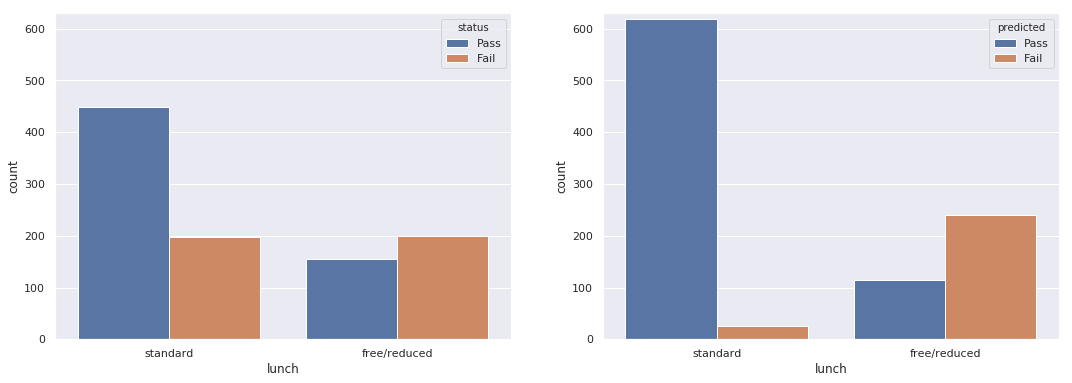

In [37]:
sns.set(rc={'figure.figsize':(18,6)})
fig, axs = plt.subplots(ncols=2)

sns.countplot(x = "lunch", hue="status", data = X_fair, ax=axs[0]).set_ylim(0,630)
sns.countplot(x = "lunch", hue="predicted", data = X_fair, ax=axs[1]).set_ylim(0,630)
plt.show()

Il grafico a sinistra mostra i reali valori della variabile target *status* al variare dell'attributo sensibile *lunch* (ovvero tipo di pasto), il grafico a destra riporta invece l'esito del classificatore, con i valori della variabile target predetti *predicted*.

In [38]:
v = X_fair.groupby("status")["lunch"].value_counts().unstack()
status_ratio = v.div(v.sum(axis="rows"), axis="columns")
print(status_ratio)

lunch   free/reduced  standard
status                        
Fail         0.56338  0.305426
Pass         0.43662  0.694574


In [39]:
v = X_fair.groupby("predicted")["lunch"].value_counts().unstack()
predicted_ratio = v.div(v.sum(axis="rows"), axis="columns")
print(predicted_ratio)

lunch      free/reduced  standard
predicted                        
Fail           0.676056   0.04031
Pass           0.323944   0.95969


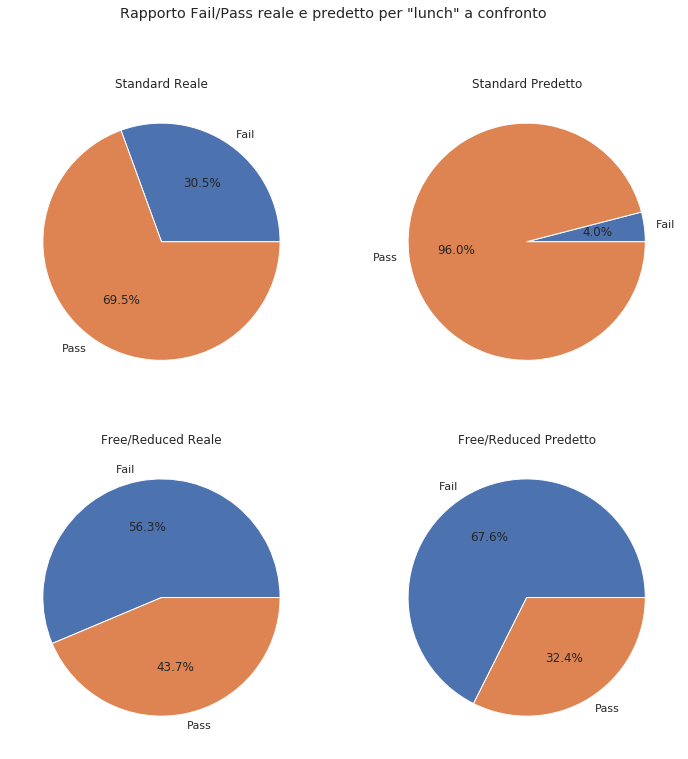

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(12,12))

fig.suptitle('Rapporto Fail/Pass reale e predetto per "lunch" a confronto')
axs[0, 0].pie(status_ratio["standard"], labels=status_ratio.index.values, autopct='%1.1f%%')
axs[0, 0].set_title('Standard Reale')
axs[0, 1].pie(predicted_ratio["standard"], labels=predicted_ratio.index.values, autopct='%1.1f%%')
axs[0, 1].set_title('Standard Predetto')
axs[1, 0].pie(status_ratio["free/reduced"], labels=status_ratio.index.values, autopct='%1.1f%%')
axs[1, 0].set_title('Free/Reduced Reale')
axs[1, 1].pie(predicted_ratio["free/reduced"], labels=predicted_ratio.index.values, autopct='%1.1f%%')
axs[1, 1].set_title('Free/Reduced Predetto')

plt.show()

Osservando i valori percentuali della variabile target, al variare dell'attributo sensibile, si può notare come questi non siano bilanciati nel dataset di partenza, e questa sproporzione viene notevolmente accentuata dal classificatore.

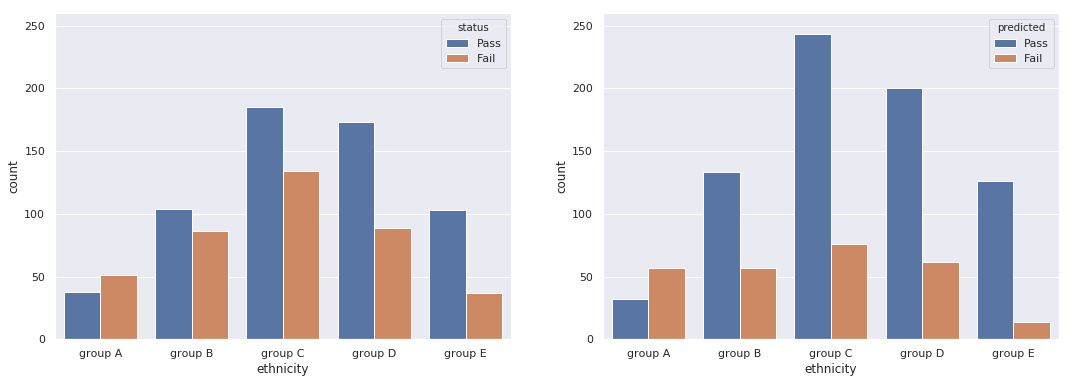

In [41]:
sns.set(rc={'figure.figsize':(18,6)})
fig, axs = plt.subplots(ncols=2)

sns.countplot(x = "ethnicity", hue="status", data = X_fair.sort_values("ethnicity"), ax=axs[0]).set_ylim(0,260)
sns.countplot(x = "ethnicity", hue="predicted", data = X_fair.sort_values("ethnicity"), ax=axs[1]).set_ylim(0,260)
plt.show()

La medesima analisi viene ripetuta al variare dell'attributo sensibile *ethnicity*.

In [42]:
v = X_fair.groupby("status")["ethnicity"].value_counts().unstack()
status_ratio = v.div(v.sum(axis="rows"), axis="columns")
print(status_ratio)

ethnicity   group A   group B   group C   group D   group E
status                                                     
Fail       0.573034  0.452632  0.420063  0.339695  0.264286
Pass       0.426966  0.547368  0.579937  0.660305  0.735714


In [43]:
v = X_fair.groupby("predicted")["ethnicity"].value_counts().unstack()
predicted_ratio = v.div(v.sum(axis="rows"), axis="columns")
print(predicted_ratio)

ethnicity   group A  group B   group C   group D  group E
predicted                                                
Fail       0.640449      0.3  0.238245  0.236641      0.1
Pass       0.359551      0.7  0.761755  0.763359      0.9


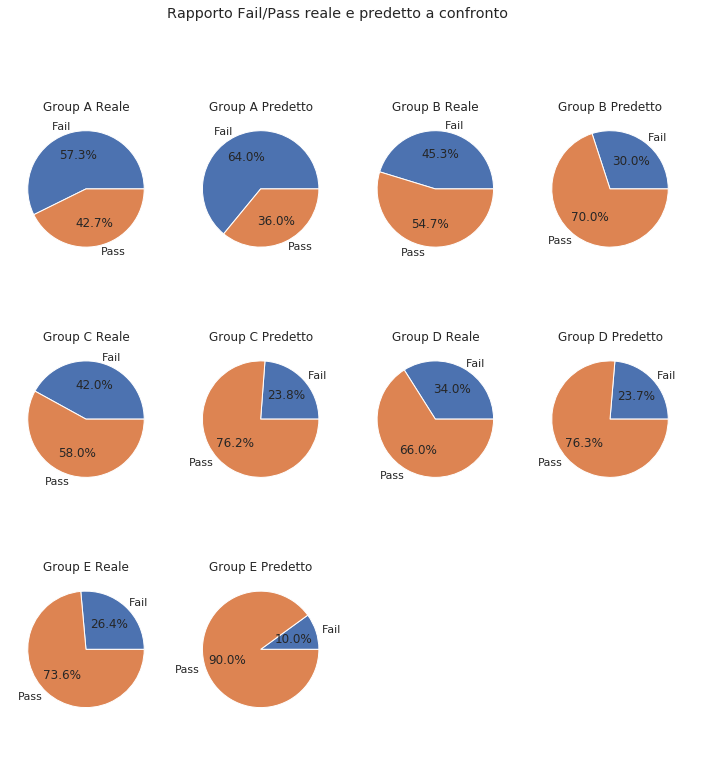

In [44]:
fig, axs = plt.subplots(3, 4, figsize=(12,12))

fig.suptitle('Rapporto Fail/Pass reale e predetto a confronto')
axs[0, 0].pie(status_ratio["group A"], labels=status_ratio.index.values, autopct='%1.1f%%')
axs[0, 0].set_title('Group A Reale')
axs[0, 1].pie(predicted_ratio["group A"], labels=predicted_ratio.index.values, autopct='%1.1f%%')
axs[0, 1].set_title('Group A Predetto')
axs[0, 2].pie(status_ratio["group B"], labels=status_ratio.index.values, autopct='%1.1f%%')
axs[0, 2].set_title('Group B Reale')
axs[0, 3].pie(predicted_ratio["group B"], labels=predicted_ratio.index.values, autopct='%1.1f%%')
axs[0, 3].set_title('Group B Predetto')
axs[1, 0].pie(status_ratio["group C"], labels=status_ratio.index.values, autopct='%1.1f%%')
axs[1, 0].set_title('Group C Reale')
axs[1, 1].pie(predicted_ratio["group C"], labels=predicted_ratio.index.values, autopct='%1.1f%%')
axs[1, 1].set_title('Group C Predetto')
axs[1, 2].pie(status_ratio["group D"], labels=status_ratio.index.values, autopct='%1.1f%%')
axs[1, 2].set_title('Group D Reale')
axs[1, 3].pie(predicted_ratio["group D"], labels=predicted_ratio.index.values, autopct='%1.1f%%')
axs[1, 3].set_title('Group D Predetto')
axs[2, 0].pie(status_ratio["group E"], labels=status_ratio.index.values, autopct='%1.1f%%')
axs[2, 0].set_title('Group E Reale')
axs[2, 1].pie(predicted_ratio["group E"], labels=predicted_ratio.index.values, autopct='%1.1f%%')
axs[2, 1].set_title('Group E Predetto')
axs[2, 2].axis('off')
axs[2, 3].axis('off')

plt.show()

Anche in questo caso la variabile target presenta un andamento estremamente eterogeneo al variare dell'attributo sensibile nel dataset di partenza, ed il classificatore in tutti quanti i gruppi incorpora questa sproporzione accentuandola notevolmente.

La conclusione che ne deriva è che il criterio di sufficienza **non è rispettato**.

<a id='p5'></a>

# 4. Criterio Separazione
    P{R = 1 | Y = 1, A = a} = P{R = 1 | Y = 1, A = b}
    P{R = 1 | Y = 0, A = a} = P{R = 1 | Y = 0, A = b}
Il criterio di separazione impone un'uguaglianza tra i tassi di veri positivi e di falsi positivi al variare dell'attributo sensibile. Impone un'equità dei tassi di errore.

Anche in questo caso gli attributi sensibili che vengono presi in considerazione sono: **ethnicity** e **lunch**.

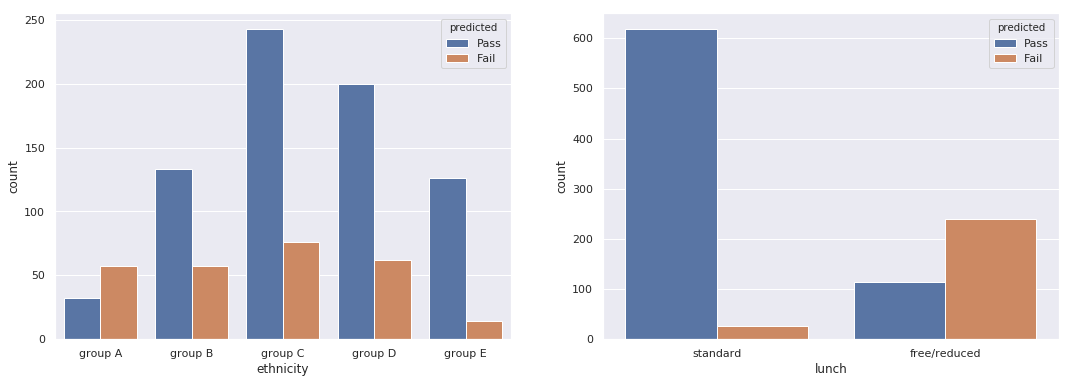

In [45]:
sns.set(rc={'figure.figsize':(18,6)})
fig, axs = plt.subplots(ncols=2)

sns.countplot(x = "ethnicity", hue="predicted", data = X_fair.sort_values("ethnicity"), ax=axs[0])
sns.countplot(x = "lunch", hue="predicted", data = X_fair, ax=axs[1])
plt.show()

Vengono riproposti i grafici che mostrano l'esito del classificatore, *Pass* o *Fail*, per entrambi gli attributi sensibili considerati.

In [46]:
# Y = 0
y0_filter = X_fair["status"] == "Fail"
# Y = 1
y1_filter = X_fair["status"] == "Pass"
# R = 0
r0_filter = X_fair["predicted"] == "Fail"
# R = 1
r1_filter = X_fair["predicted"] == "Pass"

def falseRates(a_filter):
    FP = X_fair[y0_filter & r1_filter & a_filter]
    TN = X_fair[y0_filter & r0_filter & a_filter]
    FN = X_fair[y1_filter & r0_filter & a_filter]
    TP = X_fair[y1_filter & r1_filter & a_filter]
    
    FP_n = FP.shape[0]
    FN_n = FN.shape[0]
    TP_n = TP.shape[0]
    TN_n = TN.shape[0]
    
    PPV = TP_n/(TP_n+FP_n)
    FPR = FP_n/(FP_n + TN_n)
    FNR = FN_n/(FN_n + TP_n)

    return PPV, FPR, FNR
    
def positiveRates(a_filter):    
    FP = X_fair[y0_filter & r1_filter & a_filter]
    TP = X_fair[y1_filter & r1_filter & a_filter]
    tot_F = X_fair[y0_filter & a_filter]
    tot_T = X_fair[y1_filter & a_filter]
    
    FP_n = FP.shape[0]
    TP_n = TP.shape[0]
    tot_F_n = tot_F.shape[0]
    tot_T_n = tot_T.shape[0]
    
    FP_per = FP_n/tot_F_n
    TP_per = TP_n/tot_T_n

    return FP_n, TP_n

In [47]:
a_filter = X_fair["lunch"] == "standard"
b_filter = X_fair["lunch"] == "free/reduced"

a_FP_per, a_TP_per = positiveRates(a_filter)
b_FP_per, b_TP_per = positiveRates(b_filter)
a_tot = X_fair[a_filter]
b_tot = X_fair[b_filter]

print("Veri positivi, lunch 'standard': {0:d}\nFalsi positivi, lunch 'standard': {1:d}\nTotali, lunch 'standard': {2:d}\n".format(a_TP_per, a_FP_per, a_tot.shape[0]))
print("Veri positivi, lunch 'free/reduced': {0:d}\nFalsi positivi, lunch 'free/reduced': {1:d}\nTotali, lunch 'free/reduced': {2:d}".format(b_TP_per, b_FP_per, b_tot.shape[0]))

Veri positivi, lunch 'standard': 436
Falsi positivi, lunch 'standard': 183
Totali, lunch 'standard': 645

Veri positivi, lunch 'free/reduced': 68
Falsi positivi, lunch 'free/reduced': 47
Totali, lunch 'free/reduced': 355


Calcolo dei valori *veri positivi* e *falsi positivi* per i due gruppi formati dall'attributo sensibile.

In [48]:
a_filter = X_fair["lunch"] == "standard"
b_filter = X_fair["lunch"] == "free/reduced"

a_PPV, a_FPR, a_FNR = falseRates(a_filter)
b_PPV, b_FPR, b_FNR = falseRates(b_filter)

print("Valore predittivo positivo, lunch 'standard': {0:.2f}\nValore predittivo positivo, lunch 'free/reduced': {1:.2f}\n".format(a_PPV, b_PPV))
print("Tasso falsi positivi, lunch 'standard': {0:.2f}\nTasso falsi positivi, lunch 'free/reduced': {1:.2f}\n".format(a_FPR, b_FPR))
print("Tasso falsi negativi, lunch 'standard': {0:.2f}\nTasso falsi negativi, lunch 'free/reduced': {1:.2f}\n".format(a_FNR, b_FNR))

Valore predittivo positivo, lunch 'standard': 0.70
Valore predittivo positivo, lunch 'free/reduced': 0.59

Tasso falsi positivi, lunch 'standard': 0.93
Tasso falsi positivi, lunch 'free/reduced': 0.23

Tasso falsi negativi, lunch 'standard': 0.03
Tasso falsi negativi, lunch 'free/reduced': 0.56



Si può notare un *valore predittivo positivo* migliore del caso di lunch "standard". Per la classe lunch "standard" si può inoltre notare un valore estremamente alto nel tasso di falsi positivi, ovvero il numero di casi negativi classificati incorrettamente come positivi è quasi della totalità. Lunch "standard" presenta anche un comportamento estremo nel tasso di falsi negativi, che è quasi nullo, implicando un elevato tasso di veri positivi (FNR = 1 -TPR), ovvero quasi tutti i casi con valore positivo vengono classificati correttamente.

In [49]:
df_sep_lunch = pd.DataFrame(columns=['lunch', 'TP', 'FP', 'PPV', 'FPR', 'FNR', 'TPR'])
df_sep_lunch = df_sep_lunch.append({
     "lunch": "standard",
     "TP": a_TP_per,
     "FP": a_FP_per,
     "PPV": a_PPV,
     "FPR": a_FPR,
     "FNR": a_FNR,
     "TPR": 1-a_FNR
      }, ignore_index=True)
df_sep_lunch = df_sep_lunch.append({
     "lunch": "free/reduced",
     "TP": b_TP_per,
     "FP": b_FP_per,
     "PPV": b_PPV,
     "FPR": b_FPR,
     "FNR": b_FNR,
     "TPR": 1-b_FNR
      }, ignore_index=True)

In [50]:
df_sep_lunch

,lunch,TP,FP,PPV,FPR,FNR,TPR
0,standard,436,183,0.704362,0.928934,0.026786,0.973214
1,free/reduced,68,47,0.591304,0.235000,0.561290,0.438710


In [51]:
a_filter = X_fair["ethnicity"] == "group A"
b_filter = X_fair["ethnicity"] == "group B"
c_filter = X_fair["ethnicity"] == "group C"
d_filter = X_fair["ethnicity"] == "group D"
e_filter = X_fair["ethnicity"] == "group E"

a_FP_per, a_TP_per = positiveRates(a_filter)
b_FP_per, b_TP_per = positiveRates(b_filter)
c_FP_per, c_TP_per = positiveRates(c_filter)
d_FP_per, d_TP_per = positiveRates(d_filter)
e_FP_per, e_TP_per = positiveRates(e_filter)

a_tot = X_fair[a_filter]
b_tot = X_fair[b_filter]
c_tot = X_fair[c_filter]
d_tot = X_fair[d_filter]
e_tot = X_fair[e_filter]

print("Veri positivi, ethnicity 'group A': {0:d}\nFalsi positivi, ethnicity 'group A': {1:d}\nTotali, ethnicity 'group A': {2:d}\n".format(a_TP_per, a_FP_per, a_tot.shape[0]))
print("Veri positivi, ethnicity 'group B': {0:d}\nFalsi positivi, ethnicity 'group B': {1:d}\nTotali, ethnicity 'group B': {2:d}\n".format(b_TP_per, b_FP_per, b_tot.shape[0]))
print("Veri positivi, ethnicity 'group C': {0:d}\nFalsi positivi, ethnicity 'group C': {1:d}\nTotali, ethnicity 'group C': {2:d}\n".format(c_TP_per, c_FP_per, c_tot.shape[0]))
print("Veri positivi, ethnicity 'group D': {0:d}\nFalsi positivi, ethnicity 'group D': {1:d}\nTotali, ethnicity 'group D': {2:d}\n".format(d_TP_per, d_FP_per, d_tot.shape[0]))
print("Veri positivi, ethnicity 'group E': {0:d}\nFalsi positivi, ethnicity 'group E': {1:d}\nTotali, ethnicity 'group E': {2:d}".format(e_TP_per, e_FP_per, e_tot.shape[0]))

Veri positivi, ethnicity 'group A': 18
Falsi positivi, ethnicity 'group A': 14
Totali, ethnicity 'group A': 89

Veri positivi, ethnicity 'group B': 82
Falsi positivi, ethnicity 'group B': 51
Totali, ethnicity 'group B': 190

Veri positivi, ethnicity 'group C': 161
Falsi positivi, ethnicity 'group C': 82
Totali, ethnicity 'group C': 319

Veri positivi, ethnicity 'group D': 146
Falsi positivi, ethnicity 'group D': 54
Totali, ethnicity 'group D': 262

Veri positivi, ethnicity 'group E': 97
Falsi positivi, ethnicity 'group E': 29
Totali, ethnicity 'group E': 140


Anche in questo caso viene calcolato il valore di *veri positivi* e *falsi positivi* per i gruppi formati dall'attributo sensibile, questa volta *ethnicity*.

In [52]:
a_filter = X_fair["ethnicity"] == "group A"
b_filter = X_fair["ethnicity"] == "group B"
c_filter = X_fair["ethnicity"] == "group C"
d_filter = X_fair["ethnicity"] == "group D"
e_filter = X_fair["ethnicity"] == "group E"

letters = ["a","b","c","d","e"]

a_PPV, a_FPR, a_FNR = falseRates(a_filter)
b_PPV, b_FPR, b_FNR = falseRates(b_filter)
c_PPV, c_FPR, c_FNR = falseRates(c_filter)
d_PPV, d_FPR, d_FNR = falseRates(d_filter)
e_PPV, e_FPR, e_FNR = falseRates(e_filter)

print("Valore predittivo positivo, ethnicity 'group A': {0:.2f}\nValore predittivo positivo, ethnicity 'group B': {1:.2f}\nValore predittivo positivo, ethnicity 'group C': {2:.2f}\nValore predittivo positivo, ethnicity 'group D': {3:.2f}\nValore predittivo positivo, ethnicity 'group E': {4:.2f}\n".format(a_PPV, b_PPV, c_PPV, d_PPV, e_PPV))
print("Tasso falsi positivi, ethnicity 'group A': {0:.2f}\nTasso falsi positivi, ethnicity 'group B': {1:.2f}\nTasso falsi positivi, ethnicity 'group C': {2:.2f}\nTasso falsi positivi, ethnicity 'group D': {3:.2f}\nTasso falsi positivi, ethnicity 'group E': {4:.2f}\n".format(a_FPR, b_FPR, c_FPR, d_FPR, e_FPR))
print("Tasso falsi negativi, ethnicity 'group A': {0:.2f}\nTasso falsi negativi, ethnicity 'group B': {1:.2f}\nTasso falsi negativi, ethnicity 'group C': {2:.2f}\nTasso falsi negativi, ethnicity 'group D': {3:.2f}\nTasso falsi negativi, ethnicity 'group E': {4:.2f}\n".format(a_FNR, b_FNR, c_FNR, d_FNR, e_FNR))

Valore predittivo positivo, ethnicity 'group A': 0.56
Valore predittivo positivo, ethnicity 'group B': 0.62
Valore predittivo positivo, ethnicity 'group C': 0.66
Valore predittivo positivo, ethnicity 'group D': 0.73
Valore predittivo positivo, ethnicity 'group E': 0.77

Tasso falsi positivi, ethnicity 'group A': 0.27
Tasso falsi positivi, ethnicity 'group B': 0.59
Tasso falsi positivi, ethnicity 'group C': 0.61
Tasso falsi positivi, ethnicity 'group D': 0.61
Tasso falsi positivi, ethnicity 'group E': 0.78

Tasso falsi negativi, ethnicity 'group A': 0.53
Tasso falsi negativi, ethnicity 'group B': 0.21
Tasso falsi negativi, ethnicity 'group C': 0.13
Tasso falsi negativi, ethnicity 'group D': 0.16
Tasso falsi negativi, ethnicity 'group E': 0.06



I tassi di falsi positivi e falsi negativi sono molto variabili anche all'interno dei vari gruppi dell'attributo sensibile *ethnicity*.

In [53]:
df_sep_eth = pd.DataFrame(columns=['ethnicity', 'TP', 'FP', 'PPV', 'FPR', 'FNR', 'TPR'])
df_sep_eth = df_sep_eth.append({
     "ethnicity": "group A",
     "TP": a_TP_per,
     "FP": a_FP_per,
     "PPV": a_PPV,
     "FPR": a_FPR,
     "FNR": a_FNR,
     "TPR": 1-a_FNR
      }, ignore_index=True)
df_sep_eth = df_sep_eth.append({
     "ethnicity": "group B",
     "TP": b_TP_per,
     "FP": b_FP_per,
     "PPV": b_PPV,
     "FPR": b_FPR,
     "FNR": b_FNR,
     "TPR": 1-b_FNR
      }, ignore_index=True)
df_sep_eth = df_sep_eth.append({
     "ethnicity": "group C",
     "TP": c_TP_per,
     "FP": c_FP_per,
     "PPV": c_PPV,
     "FPR": c_FPR,
     "FNR": c_FNR,
     "TPR": 1-c_FNR
      }, ignore_index=True)
df_sep_eth = df_sep_eth.append({
     "ethnicity": "group D",
     "TP": d_TP_per,
     "FP": d_FP_per,
     "PPV": d_PPV,
     "FPR": d_FPR,
     "FNR": d_FNR,
     "TPR": 1-d_FNR
      }, ignore_index=True)
df_sep_eth = df_sep_eth.append({
     "ethnicity": "group E",
     "TP": e_TP_per,
     "FP": e_FP_per,
     "PPV": e_PPV,
     "FPR": e_FPR,
     "FNR": e_FNR,
     "TPR": 1-e_FNR
      }, ignore_index=True)

In [54]:
df_sep_eth

,ethnicity,TP,FP,PPV,FPR,FNR,TPR
0,group A,18,14,0.562500,0.274510,0.526316,0.473684
1,group B,82,51,0.616541,0.593023,0.211538,0.788462
2,group C,161,82,0.662551,0.611940,0.129730,0.870270
3,group D,146,54,0.730000,0.606742,0.156069,0.843931
4,group E,97,29,0.769841,0.783784,0.058252,0.941748


<a id='p6'></a>

# 5. Fattori di Rischio e Conclusioni

Il Data Impact Assessment eseguito, seppur con diversi limiti quali l'esiguo numero di dati disponibili e il conseguente utilizzo di classificatori con un test score non elevato, ha messo in luce alcune criticità. 

Un classificatore (e dunque una scelta quale *"la possibilità di avere o meno un voto sufficiente in tutte le materie"*) basato sui valori forniti da un dataset di questo tipo è fortemente influenzato dagli attributi **ethnicity** e **lunch**.

L'attributo sensibile *gender*, come dimostrato dall'analisi e dall'importanza riservata a questa feature nel classificatore, non ha un impatto discriminatorio su quest'ultimo (il numero di studenti maschi e femmine è circa uguale e con una distribuzione simile all'interno dei vari gruppi etnici, non andando ad influenzare i voti conseguiti nelle materie). Un discorso simile può essere fatto per *parent education*.  
  L'attributo *preparation* ha invece un impatto leggermente più significativo sul classificatore, dovuto a come il completamento di un corso di preparazione comporti un miglioramento del punteggio in tutte le materie, ovvero un risultato coerente ed auspicabile.

Se vengono presi in considerazione gli attributi *ethnicity* e *lunch* (con quest'ultimo legato ad eventuali agevolazioni sui pasti a mensa, da considerare come una sorta di indicatore economico della famiglia dello studente) l'equità del classificatore rischia di essere seriamente compromessa. Il numero considerevolmente diverso di studenti all'interno dei vari gruppi, i differenti risultati conseguiti in termini di voto e risultato, portano ad una classificazione che non rispetta né il criterio di sufficienza né quello di separazione. I tassi di falsi positivi e negativi sono estremamente variabili e il classificatore sembra inglobare totalmente le tendenze della maggioranza, accentuando qualsiasi sproporzione presente nel dataset di partenza.   
  Uno studente brillante appartenente ad un gruppo etnico di minoranza e con difficoltà economiche, che possono dare diritto alla modalità di pasto *"free/reduced"*, avrà elevate possibilità di venir erroneamente classificato con esito *"Fail"*.